<a href="https://www.kaggle.com/code/ziadhamadafathy/predict-rain-tomorrow-in-australia-acc-92?scriptVersionId=110905352" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/australia-weather-data/Weather Training Data.csv
/kaggle/input/australia-weather-data/Weather Test Data.csv


# Preparing data

In [2]:
df_train = pd.read_csv('../input/australia-weather-data/Weather Training Data.csv')
df_test = pd.read_csv('../input/australia-weather-data/Weather Test Data.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)

(99516, 23)
(42677, 22)


In [4]:
df_train

,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99511,Row101816,Uluru,8.0,20.7,0.0,NaN,NaN,ESE,41.0,SE,...,56.0,32.0,1028.1,1024.3,NaN,7.0,11.6,20.0,No,0
99512,Row101817,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,0
99513,Row101818,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,0
99514,Row101819,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,0


In [5]:
X = df_train.drop(columns=['RainTomorrow'])
y = df_train['RainTomorrow']
df = pd.concat([X, df_test], axis=0)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,141556.0,12.186400,6.403283,-8.5,7.6,12.0,16.8,33.9
MaxTemp,141871.0,23.226784,7.117618,-4.8,17.9,22.6,28.2,48.1
Rainfall,140787.0,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0
Evaporation,81350.0,5.469824,4.188537,0.0,2.6,4.8,7.4,145.0
Sunshine,74377.0,7.624853,3.781525,0.0,4.9,8.5,10.6,14.5
WindGustSpeed,132923.0,39.984292,13.588801,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,140845.0,14.001988,8.893337,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,139563.0,18.637576,8.803345,0.0,13.0,19.0,24.0,87.0
Humidity9am,140419.0,68.843810,19.051293,0.0,57.0,70.0,83.0,100.0
Humidity3pm,138583.0,51.482606,20.797772,0.0,37.0,52.0,66.0,100.0


# Data Cleaning

In [7]:
df.drop(columns='row ID', inplace=True)

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Sunshine,67816,0.476929
Evaporation,60843,0.427890
Cloud3pm,57094,0.401525
Cloud9am,53657,0.377353
Pressure9am,14014,0.098556
Pressure3pm,13981,0.098324
WindDir9am,10013,0.070418
WindGustDir,9330,0.065615
WindGustSpeed,9270,0.065193
WindDir3pm,3778,0.026570


In [9]:
df.drop(columns=['Sunshine', 'Evaporation'], inplace=True)

In [10]:
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
dtype: object

**Fill null values categorical with the mode**

In [11]:
categorical = df.select_dtypes(include = "object").columns
cleaner = ColumnTransformer([
    ('categorical_transformer', SimpleImputer(strategy='most_frequent'), categorical)
])
df[categorical] = cleaner.fit_transform(df[categorical])

In [12]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
dtype: int64

**Fill null values numerical with median**

In [13]:
df = df.fillna(df.median())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


**To sure is not found null values**

In [14]:
df.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

**To know the values of each categorical features**

In [15]:
categorical = df.select_dtypes(include = "object").columns
for i in range(len(categorical)):
    print(df[categorical[i]].value_counts())
    print('************************************\n')

Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Launceston          3028
Ballarat            3028
Albany              3016
Albury              3011
PerthAirport        3009
MelbourneAirport    3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cairns              2988
Cobar               2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
Penrith             2964
NorfolkIsland       2964
SalmonGums          2955
Newcastle           2955
CoffsHarbour        2953
Witchcliffe         2952
Richmond            2951
Dartmoor            2943
NorahHead           2929
BadgerysCreek       2928


**Convert values form categorical to numrical values**

In [16]:
objects = df.select_dtypes(include = "object").columns
for i in range(len(objects)):
    df[objects[i]] = LabelEncoder().fit_transform(df[objects[i]])

In [17]:
df

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2,13.4,22.9,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0
1,2,7.4,25.1,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0
2,2,17.5,32.3,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0
3,2,14.6,29.7,0.2,14,56.0,13,13,19.0,24.0,55.0,23.0,1009.2,1005.4,5.0,5.0,20.6,28.9,0
4,2,7.7,26.7,0.0,13,35.0,10,13,6.0,17.0,48.0,19.0,1013.4,1010.1,5.0,5.0,16.3,25.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42672,41,2.4,19.1,0.0,0,33.0,9,0,17.0,17.0,59.0,24.0,1030.0,1026.2,5.0,5.0,8.0,18.8,0
42673,41,2.3,21.4,0.0,9,22.0,9,10,11.0,7.0,60.0,28.0,1026.9,1022.8,5.0,5.0,8.9,20.3,0
42674,41,2.6,22.5,0.0,8,19.0,8,0,9.0,7.0,59.0,24.0,1025.0,1021.4,5.0,5.0,8.8,22.1,0
42675,41,7.4,20.6,0.0,0,35.0,2,0,15.0,17.0,63.0,33.0,1027.2,1023.3,5.0,5.0,11.0,20.3,0


In [18]:
train = df.iloc[:99516,:]
new_train = pd.concat([train, y], axis=1)
test = df.iloc[99516:, :]

In [19]:
new_train

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2,13.4,22.9,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0
1,2,7.4,25.1,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0
2,2,17.5,32.3,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
3,2,14.6,29.7,0.2,14,56.0,13,13,19.0,24.0,55.0,23.0,1009.2,1005.4,5.0,5.0,20.6,28.9,0,0
4,2,7.7,26.7,0.0,13,35.0,10,13,6.0,17.0,48.0,19.0,1013.4,1010.1,5.0,5.0,16.3,25.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99511,41,8.0,20.7,0.0,2,41.0,9,0,19.0,26.0,56.0,32.0,1028.1,1024.3,5.0,7.0,11.6,20.0,0,0
99512,41,3.5,21.8,0.0,0,31.0,2,0,15.0,13.0,59.0,27.0,1024.7,1021.2,5.0,5.0,9.4,20.9,0,0
99513,41,2.8,23.4,0.0,0,31.0,9,1,13.0,11.0,51.0,24.0,1024.6,1020.3,5.0,5.0,10.1,22.4,0,0
99514,41,3.6,25.3,0.0,6,22.0,9,3,13.0,9.0,56.0,21.0,1023.5,1019.1,5.0,5.0,10.9,24.5,0,0


# Visualize for some important features

**Correlation among features**

<AxesSubplot:>

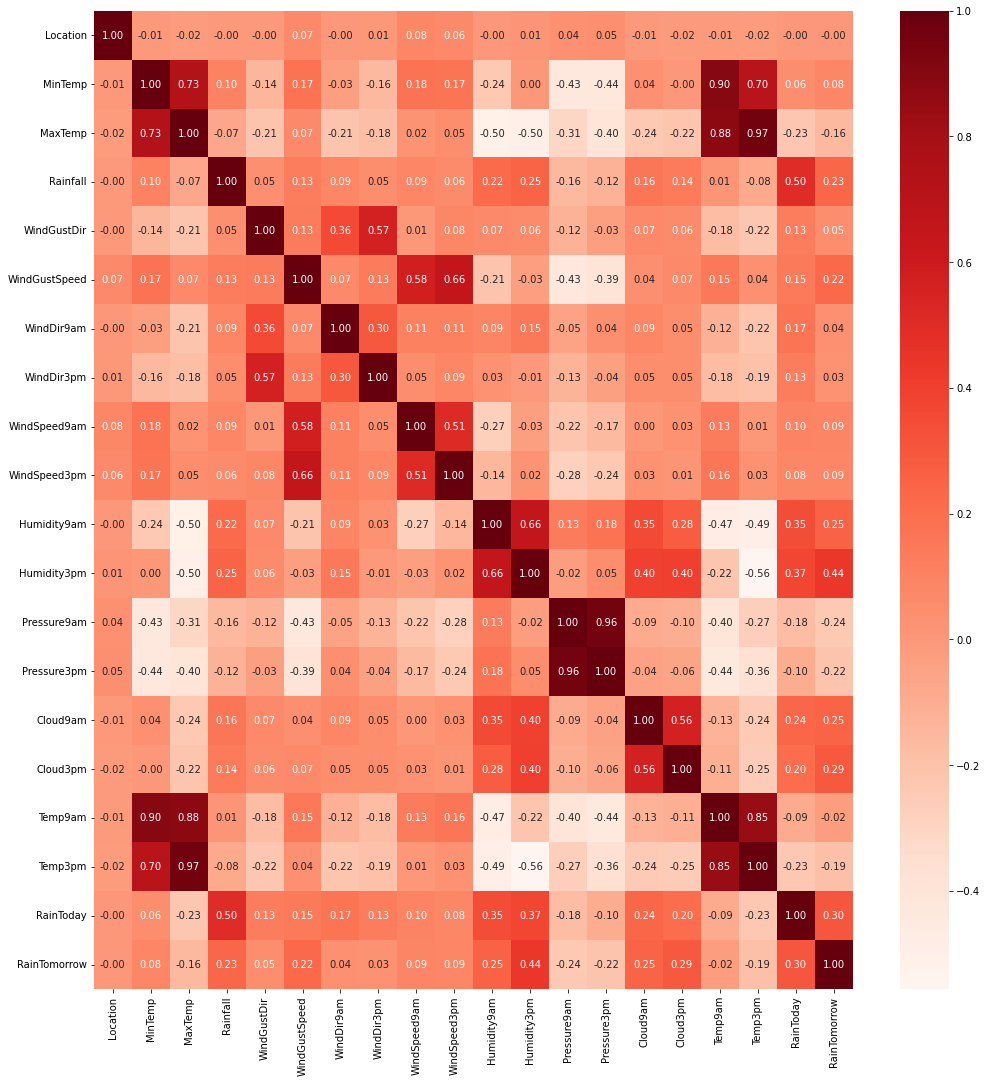

In [20]:
plt.figure(figsize=(17,18))
cor = new_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,fmt='.2f')

<AxesSubplot:xlabel='Humidity9am', ylabel='Count'>

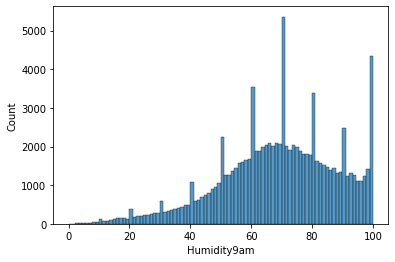

In [21]:
sns.histplot(new_train['Humidity9am'])

<AxesSubplot:xlabel='Humidity3pm', ylabel='Count'>

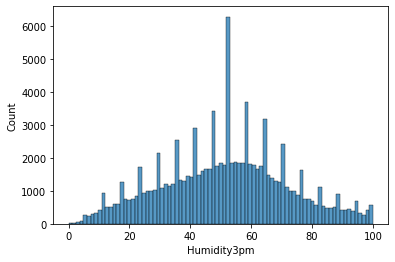

In [22]:
sns.histplot(new_train['Humidity3pm'])

<AxesSubplot:xlabel='Cloud9am'>

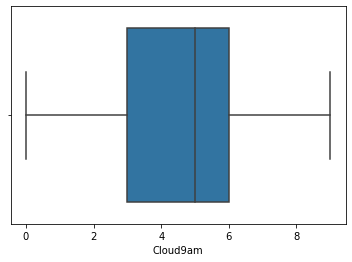

In [23]:
sns.boxplot(x=new_train['Cloud9am'])

<AxesSubplot:xlabel='Cloud3pm'>

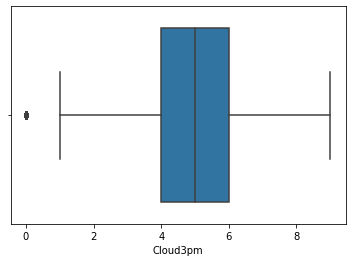

In [24]:
sns.boxplot(x=new_train['Cloud3pm'])

<AxesSubplot:xlabel='RainToday', ylabel='count'>

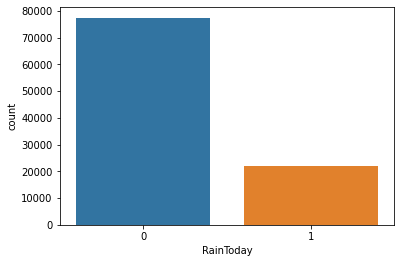

In [25]:
sns.countplot(x=new_train['RainToday'])

In [26]:
new_train['RainTomorrow'].value_counts()

0    77157
1    22359
Name: RainTomorrow, dtype: int64

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

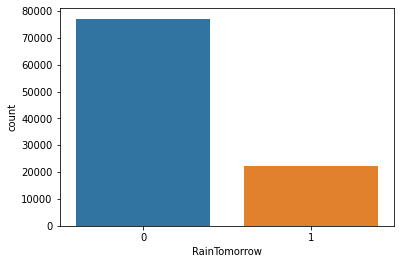

In [27]:
sns.countplot(x=new_train['RainTomorrow'])

# Balancing dataset

In [28]:
df_majority_0 = new_train[(new_train['RainTomorrow']==0)] 
df_minority_1 = new_train[(new_train['RainTomorrow']==1)] 

df_minority_upsampled = resample(df_minority_1, 
                                 replace=True,    
                                 n_samples= 77157, 
                                 random_state=42) 

df_upsampled = pd.concat([df_minority_upsampled, df_majority_0])

**Correlation among features after balancing**

<AxesSubplot:>

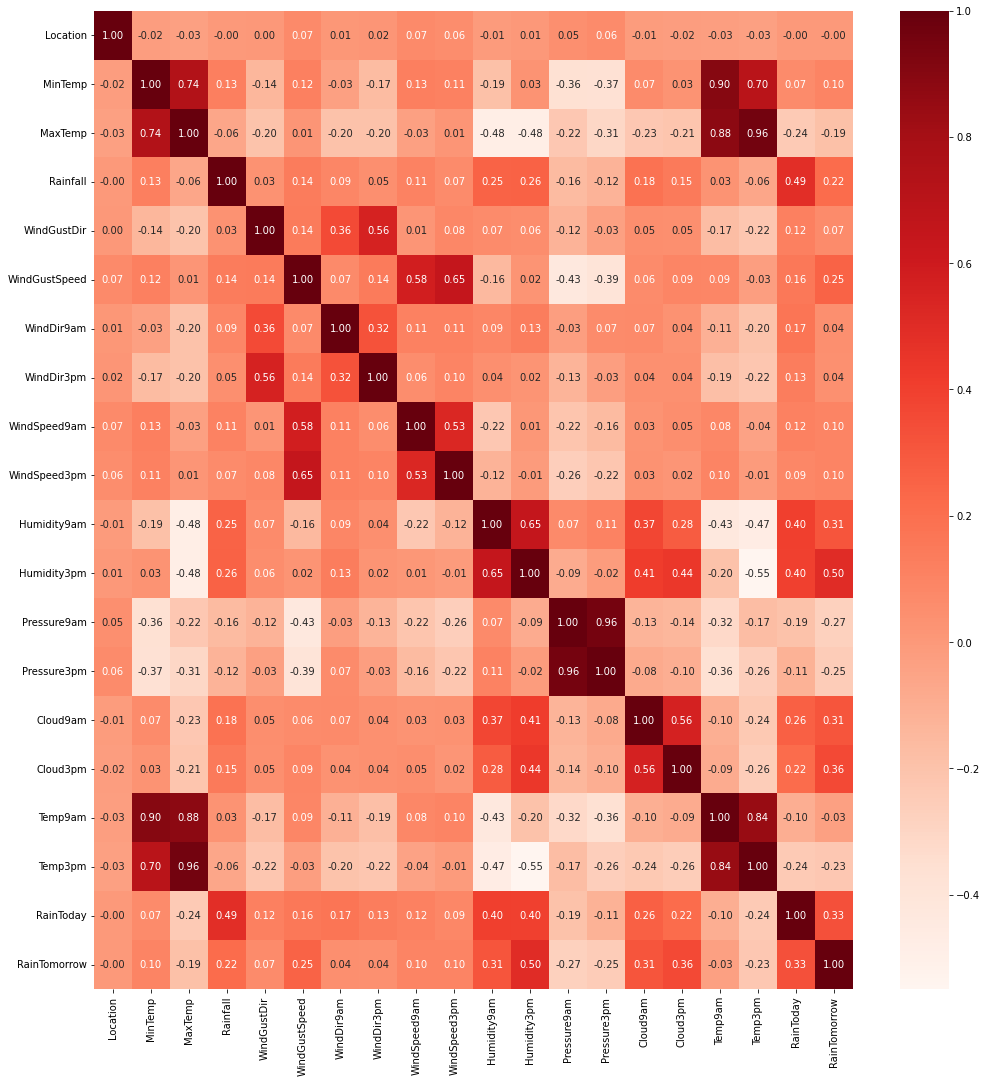

In [29]:
plt.figure(figsize=(17,18))
cor = df_upsampled.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,fmt='.2f')

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

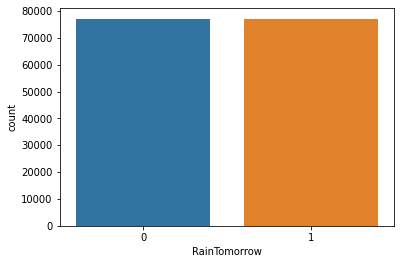

In [30]:
sns.countplot(x=df_upsampled['RainTomorrow'])

**Splitting data for modeling**

In [31]:
X = df_upsampled.drop(columns='RainTomorrow')
y = df_upsampled['RainTomorrow']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True, random_state=44)

# Two ML models

**Random Forest model**

In [33]:
RandomForestClassifierModel = RandomForestClassifier(criterion = 'gini', max_depth=17, n_estimators=100, random_state=44)
RandomForestClassifierModel.fit(X_train, y_train)

print('RandomForestClassifierModel Train Score is : ' , RandomForestClassifierModel.score(X_train, y_train))
print('RandomForestClassifierModel Test Score is : ' , RandomForestClassifierModel.score(X_test, y_test))

RandomForestClassifierModel Train Score is :  0.9770452614449676
RandomForestClassifierModel Test Score is :  0.921461897356143


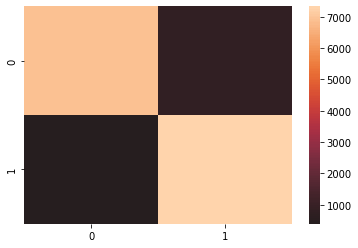

Confusion Matrix is
 [[6887  822]
 [ 390 7333]]


In [34]:
y_pred_RF = RandomForestClassifierModel.predict(X_test)
CM_RF = confusion_matrix(y_test, y_pred_RF)

sns.heatmap(CM_RF, center=True)
plt.show()

print('Confusion Matrix is\n', CM_RF)

**Gradient Boosting**

In [35]:
GBCModel = GradientBoostingClassifier(n_estimators=200, max_depth=11, learning_rate=0.07, random_state=44)
GBCModel.fit(X_train, y_train)
print('GBCModel Train Score is : ' , GBCModel.score(X_train, y_train))
print('GBCModel Test Score is : ' , GBCModel.score(X_test, y_test))

GBCModel Train Score is :  0.9894586771503867
GBCModel Test Score is :  0.9320891653706583


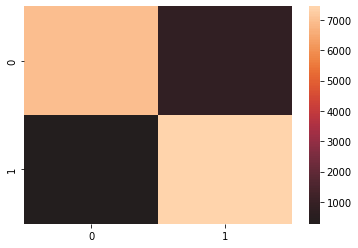

Confusion Matrix is
 [[6941  768]
 [ 280 7443]]


In [36]:
y_pred_GB = GBCModel.predict(X_test)
CM_GB = confusion_matrix(y_test, y_pred_GB)

sns.heatmap(CM_GB, center=True)
plt.show()

print('Confusion Matrix is\n', CM_GB)

# Test data predicting

**We will use gradient boosting to predict test data**

In [37]:
y_pred = GBCModel.predict(test)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

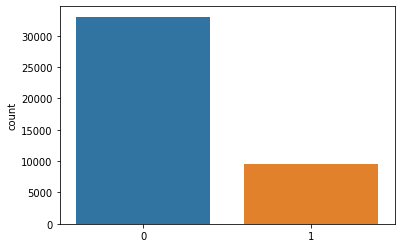

In [38]:
sns.countplot(y_pred)

In [39]:
test = pd.read_csv('../input/australia-weather-data/Weather Test Data.csv')
submission = test[["row ID"]]
submission["RainTomorrow"] = y_pred

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
submission.to_csv('../predict_weather.csv', index=False)